# Prediction using rainfall data

The best model without rainfall data is LastDayModel. It just predicts that the flow next day will be the same like today

In this notebook we try to improve this model by using precipitation information and testing the following features:
  * Predict next 24h at once
  * Use time of the day
  * Use total precipitation in the last N hours

In [1]:
import datetime
import time
import calendar
import json
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project

In [2]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
flow_rain = pd.concat([flow, rainfall], axis=1).dropna()
flow_rain = flow_rain['2015-06-02':'2017-11-09']
print(flow_rain.head())
print(flow_rain.tail())
flow = flow_rain['flow']
rainfall = flow_rain['rainfall']

{
    "end-date": "2017-10-01",
    "rainfalls": [
        "rainfall1"
    ],
    "flows": [
        "flow1"
    ],
    "start-date": "2015-06-02",
    "name": "thorium-medium",
    "split-date": "2017-01-01"
}
                           flow  rainfall
time                                     
2015-06-02 00:00:00  100.889999       0.0
2015-06-02 00:05:00   99.839996       0.0
2015-06-02 00:10:00   99.279999       0.0
2015-06-02 00:15:00   98.139999       0.0
2015-06-02 00:20:00   97.110001       0.0
                           flow  rainfall
time                                     
2017-11-09 23:35:00  111.739998       0.0
2017-11-09 23:40:00  110.949997       0.0
2017-11-09 23:45:00  110.519997       0.0
2017-11-09 23:50:00  109.190002       0.0
2017-11-09 23:55:00  107.089996       0.0


## Helper functions

Helper functions for building training and test sets and calculating score

In [33]:
class PredictionModel:
    """Mean model as a reference baseline"""
    
    def fit(self, flow, rain):
        self.mean = np.mean(flow.values)
        
    def predict(self, day, rain):
        return np.ones(288) * self.mean
    
    
def loss(y_hat, y):
    """
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    """
    return 100.0 * np.sum(np.abs((y-y_hat) / y)) / y.shape[0]


def split_data(flow, split_day):
    """Get all data up to given day"""
    end_day = split_day - pd.Timedelta('1 min')
    return flow[:end_day]


def evaluate_day(model, flow, rain, split_day):
    """Evaluate data for single day"""
    xs = split_data(flow, split_day)
    next_day = split_day + pd.Timedelta(1, 'D')
    y = flow[next_day: next_day+pd.Timedelta('1439 min')]
    model.fit(xs, rain)
    y_hat = model.predict(next_day, rain)
    return loss(y_hat, y)


def evaluate_model(model, flow, rain, start_day):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    last_day = flow.index[-1] - pd.Timedelta(1, 'D')
    split_day = start_day
    costs = []
    while split_day < last_day:
        cost = evaluate_day(model, flow, rain, split_day)
        costs.append(cost)
        split_day += pd.Timedelta(1, 'D')
    return np.percentile(costs, 95), costs


def plot_prediction(model, day):
    ts = pd.Timestamp(day)
    pred = model.predict(ts, rainfall)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(pred, label='Prediction')
    ax.plot(flow[ts: ts+pd.Timedelta('1439 min')].values, label='Flow')
    plt.title(day)
    ax.legend()
    plt.show()


score, costs = evaluate_model(PredictionModel(), flow, rainfall, pd.Timestamp('2017-01-01'))
print('MeanModel score: {:.2f}% (expected: 22.69%)'.format(score))

MeanModel score: 22.69% (expected: 22.69%)


## Base line model

This is the best model without rainfall data

LastDayModel score: 17.86%


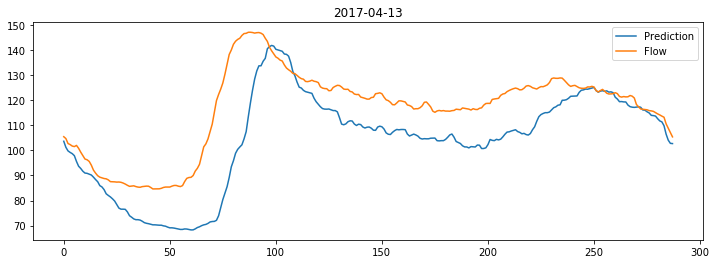

In [34]:
class LastDayModel(PredictionModel):
    
    def fit(self, flow, rain):
        self.y = flow.values[-288:]
        
    def predict(self, day, rain):
        return self.y
    
model = LastDayModel()
score, costs = evaluate_model(model, flow, rainfall, pd.Timestamp('2017-01-01'))
print('LastDayModel score: {:.2f}%'.format(score))
plot_prediction(model, '2017-04-13')

# Extract features

Extract the following features:

  * Minutes of the day
  * Total precipitation in the last N hours

In [35]:
def encode_time(xs):
    """
    Encode time as Int value
    Params:
      times - pd.Series with Timestamp
    Return:
      pd.Series with encoded time
    """
    return xs.map(lambda x: x.hour*60+x.minute)


def encode_features(flow, rain, last_rain_window = 2):
    """
    Create feature vector based on 
    Return feature and expected values
    """
    df = pd.concat([flow, rain], axis=1).reset_index()
    df['last_rain'] = df.rainfall.rolling(last_rain_window*12).sum()
    df['minutes'] = encode_time(df.time)
    df = df.dropna()
    return (df[['minutes', 'last_rain']], df.flow)


def prepare_prediction_features(day, rain, last_rain_window = 2):
    last_rain = rain.rolling(last_rain_window*12).sum()
    ts = pd.date_range(day, periods=288, freq='5T')
    minutes = pd.Series(data=encode_time(ts), index=ts)
    df = pd.concat([minutes, last_rain], axis=1).dropna()
    return df

# Models

## Linear regression

As a baseline lets try Linear Model

LinearModel score: 19.98%
Calculated in 289.658 seconds
Model coef: [ 0.026961    0.89859435], intercept: 89.01508385547154


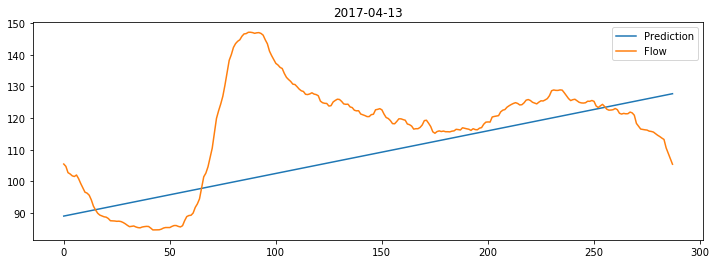

In [36]:
from sklearn.linear_model import LinearRegression

class LinearModel(PredictionModel):
    
    def fit(self, flow, rain):
        X, y = encode_features(flow, rain)
        self.clf = LinearRegression()
        self.clf.fit(X, y)
        
    def predict(self, day, rain):
        X = prepare_prediction_features(day, rain)
        return self.clf.predict(X)    

start_time = time.time()
model = LinearModel()
score, costs = evaluate_model(model, flow_rain.flow, flow_rain.rainfall, pd.Timestamp('2017-01-01'))
print('LinearModel score: {:.2f}%'.format(score))
print("Calculated in {:.3f} seconds".format(time.time() - start_time))
print('Model coef: {}, intercept: {}'.format(model.clf.coef_, model.clf.intercept_))
plot_prediction(model, '2017-04-13')

## Decision Tree Regressor

First not linear model. Should improve on linear model

In [24]:
from sklearn import tree

class DTModel(PredictionModel):
    
    def __init__(self, rain_window_size=2):
        self.rain_window_size = rain_window_size
    
    def fit(self, flow, rain):
        X, y = encode_features(flow, rain, self.rain_window_size)
        self.clf = tree.DecisionTreeRegressor()
        self.clf.fit(X, y)
        
    def predict(self, day, rain):
        X = prepare_prediction_features(day, rain, self.rain_window_size)
        return self.clf.predict(X)
    

start_time = time.time()
score, costs = evaluate_model(DTModel(2), flow_rain.flow, flow_rain.rainfall, pd.Timestamp('2017-01-01'))
print('DTModel 2h score: {:.2f}%'.format(score))
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

DTModel 2h score: 20.40%
Calculated in 283.027 seconds


## XGBoost

In [27]:
import xgboost as xg

class XGBoostModel(PredictionModel):
    
    def __init__(self, rain_window_size=2):
        self.rain_window_size = rain_window_size
    
    def fit(self, flow, rain):
        X, y = encode_features(flow, rain, self.rain_window_size)
        self.clf = xg.XGBRegressor()
        self.clf.fit(X.values, y.values)
        
    def predict(self, day, rain):
        X = prepare_prediction_features(day, rain, self.rain_window_size)
        return self.clf.predict(X.values)
    
    def encode_time(self, time):
        return time.hour*60+time.minute
    

start_time = time.time()
score, costs = evaluate_model(XGBoostModel(2), flow_rain.flow, flow_rain.rainfall, pd.Timestamp('2017-01-01'))
print('XGBoostModel 2h score: {:.2f}'.format(score))
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

XGBoostModel 2h score: 17.36
Calculated in 871.612 seconds
